In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

#### weighting factor

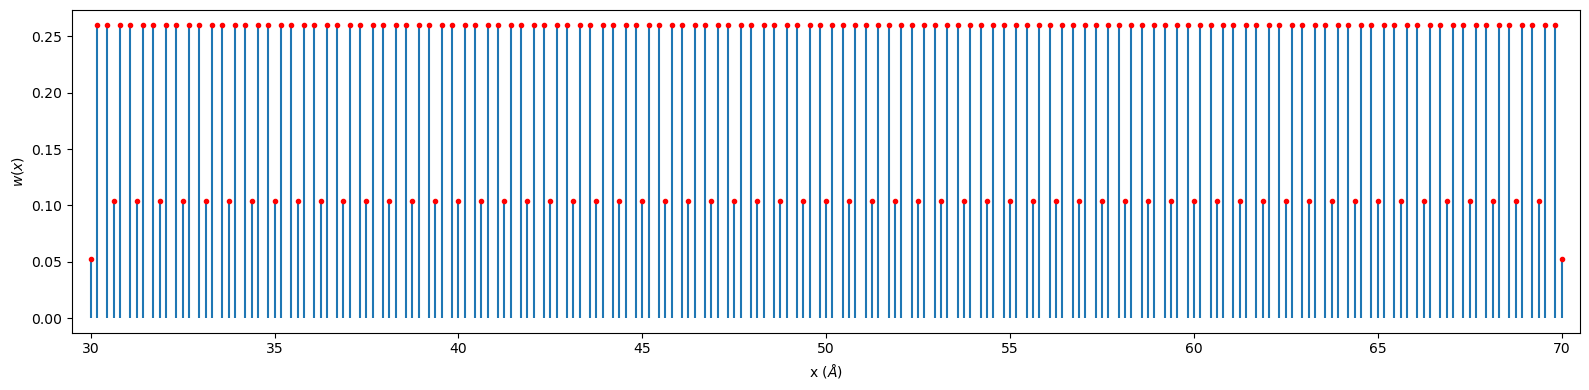

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
ax.plot(xref, w0, "r.")
ax.vlines(xref, ymin=0, ymax=w0)
ax.set_ylabel("\$w(x)\$")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_xlim(29.5, 70.5)
plt.tight_layout()
#plt.savefig("weight_function.png", dpi=200)
plt.show()

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1

### Part 3: Read Trajectory

#### physical parameters about simulations

In [4]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

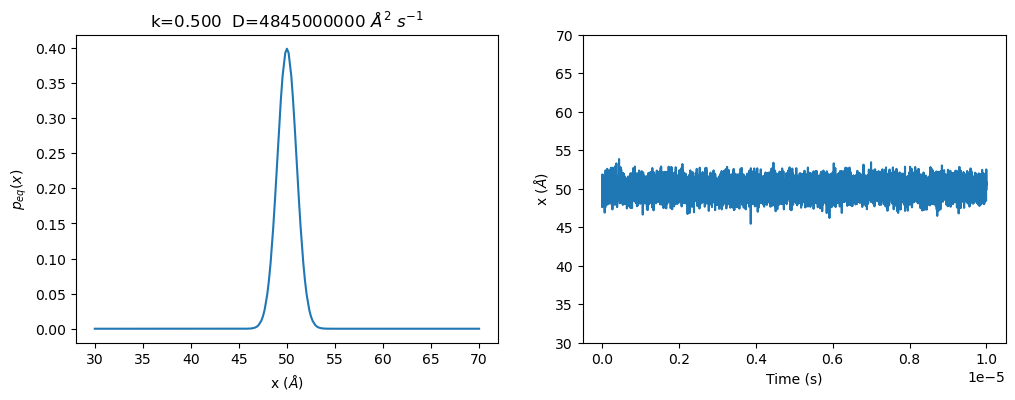

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Get eigenvalues and eigenvectors

In [7]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

In [58]:
yarray_1 = zeros(Nv)
yarray_2 = zeros(Nv)
for i = 1:Nv
    yarray_1[i] = sum( w0 .* Qx[:,i] .* Qx[:,i])
    yarray_2[i] = dot(Qx[:,i], Qx[:,i])
end

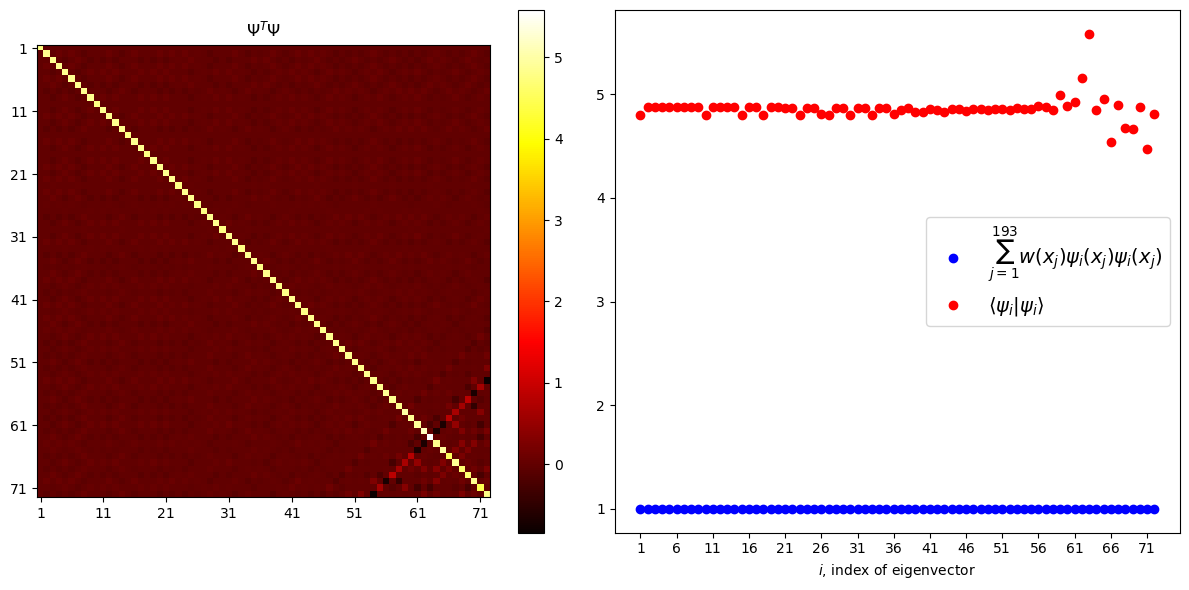

In [84]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

ax = axes[1]
I_matrix = transpose(Qx) * Qx
im = ax.imshow(I_matrix, cmap="hot")
title = "\$ \\Psi^{T} \\Psi \$"
ax.set_title(title)
cbar = fig.colorbar(im, ax=ax, shrink=1)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_xticklabels(["1", "11", "21", "31", "41", "51", "61", "71"])
ax.set_yticklabels(["1", "11", "21", "31", "41", "51", "61", "71"])

ax = axes[2]
xarray = 1:Nv
label1 = "\$ \\sum_{j=1}^{193} w(x_j) \\psi_i(x_j) \\psi_i(x_j) \$"
label2 = "\$ \\langle \\psi_i | \\psi_i  \\rangle \$"

ax.plot(xarray, yarray_1, "bo", label=label1)
ax.plot(xarray, yarray_2, "ro", label=label2)
ax.set_xticks(1:5:72)
ax.set_xlabel("\$i\$, index of eigenvector")
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("eigenvec_matrix_complete.png", dpi=200)
plt.show()

### Part 5: Plot $ \left< \alpha_{t_0} \right|$

In [11]:
alpha_t0 = transpose(Qx) * rho_eq
alpha_t0_norm = sqrt(dot(alpha_t0, alpha_t0));

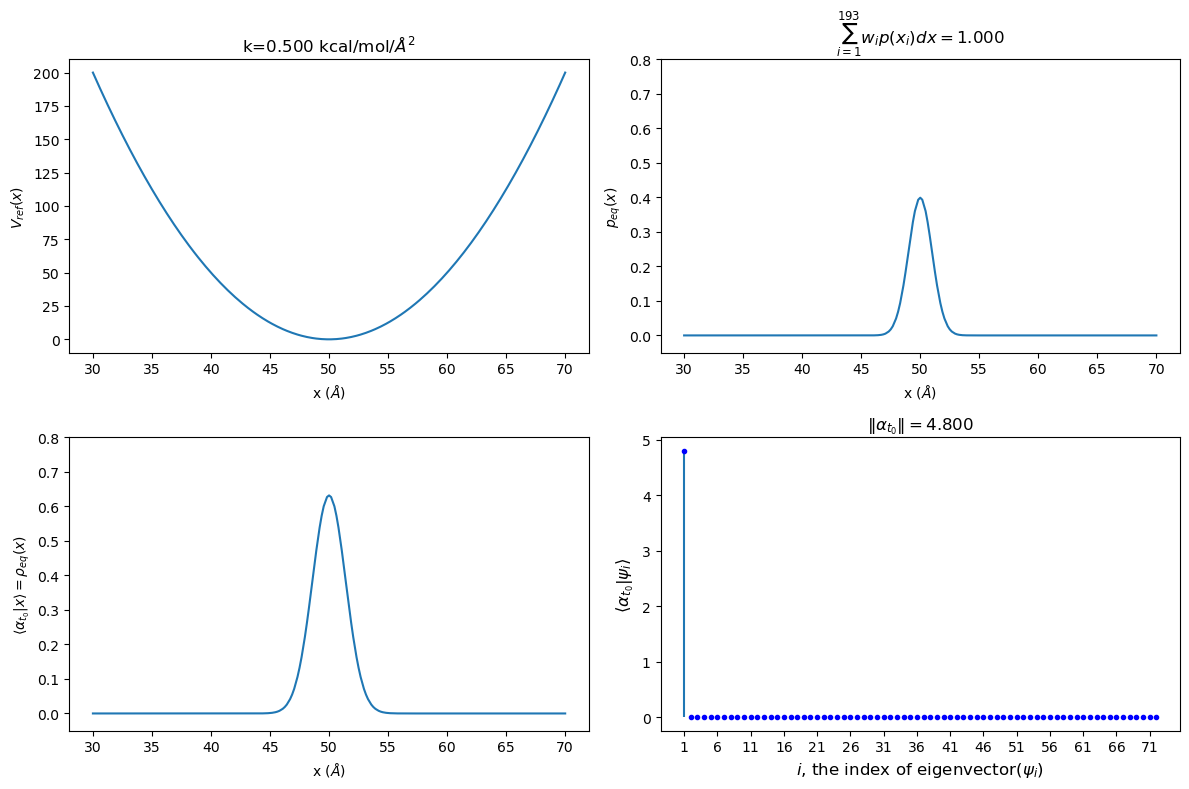

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

ax = axes[1,1]
ax.plot(xref, V_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ V_{ref}(x) \$")
title = @sprintf "k=%.3f kcal/mol/\$\\AA^2\$" k_ref 
ax.set_title(title)

ax = axes[1,2]
ax.plot(xref, peq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "\$ \\sum_{i=1}^{193}w_i p(x_i)dx=%.3f \$" sum(w0 .* peq)
ax.set_title(title)
ax.set_ylim(-0.05, 0.8)

ax = axes[2,1]
ax.plot(xref, rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x \\rangle = \\rho_{eq}(x) \$")
ax.set_ylim(-0.05, 0.8)

ax = axes[2,2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("alpha_t0.png", dpi=150)
plt.show()

### Part : Test

In [21]:
sum(w0 .* Qx[:,1] .* Qx[:,2])

3.28312617333727e-18

In [20]:
sum(Qx[:,1] .* Qx[:,5])

-1.7435678978179628e-6

In [65]:
alpha_t0 = transpose(Qx) * rho_eq
alpha_t0_norm = dot(alpha_t0, alpha_t0)
rho_eq_by_alpha_t0 = Qx * alpha_t0;

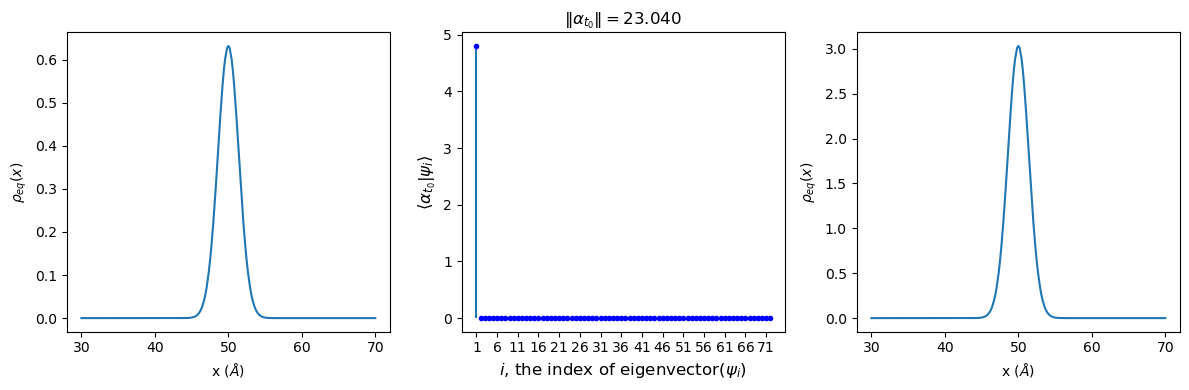

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ \\rho_{eq}(x) \$")

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

ax = axes[3]
ax.plot(xref, rho_eq_by_alpha_t0)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$\\rho_{eq}(x) \$")

plt.tight_layout()
plt.show()

### Part 6: Plot $ \left< \alpha_{t_0}| e^{-\textbf{H}\Delta t} \right|$

In [62]:
expLQDT = exp.(-Lambdas .* dt)
alpha_t0_e_delta_t = expLQDT .* alpha_t0
alpha_t0_e_delta_t_norm = dot(alpha_t0_e_delta_t, alpha_t0_e_delta_t);
alpha_t0_e_delta_t_x = Qx * alpha_t0
p_delta_t = rho_eq .* alpha_t0_e_delta_t_x;

In [28]:
expLQDT = exp.(-Lambdas .* dt)
alpha_t0_e_delta_t = expLQDT .* alpha_t0
alpha_t0_e_delta_t_norm = sqrt(dot(alpha_t0_e_delta_t, alpha_t0_e_delta_t));

alpha_t0_e_delta_t_x = Qx * alpha_t0_e_delta_t
p_delta_t = rho_eq .* alpha_t0_e_delta_t_x

temp_factor = sum(w0 .* p_delta_t)
p_delta_t = p_delta_t ./ temp_factor
alpha_t0_e_delta_t_x = p_delta_t ./ rho_eq;

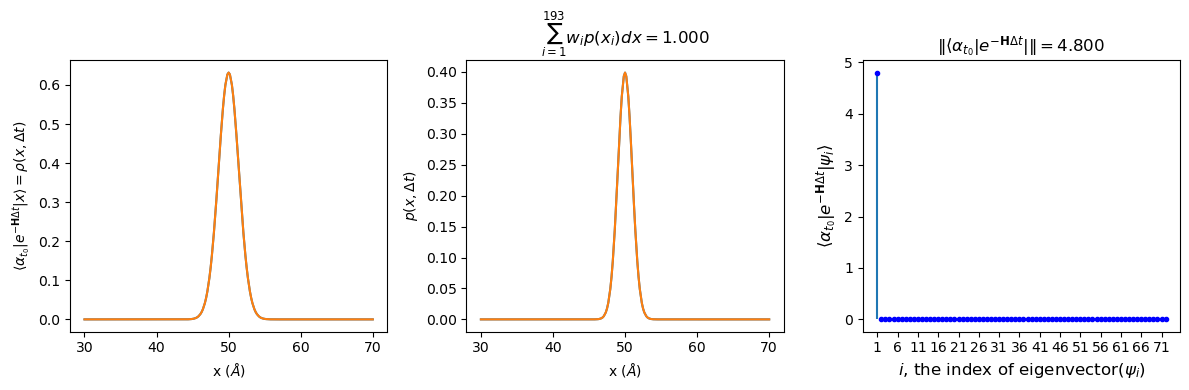

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq)
ax.plot(xref, alpha_t0_e_delta_t_x)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | e^{-\\mathbf{H} \\Delta t}| x \\rangle = \\rho(x, \\Delta t) \$")

ax = axes[2]
ax.plot(xref, p_delta_t)
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$p(x, \\Delta t) \$")
title = @sprintf "\$ \\sum_{i=1}^{193}w_i p(x_i)dx=%.3f \$" sum(w0 .* p_delta_t)
ax.set_title(title)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | e^{-\\mathbf{H} \\Delta t} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert\\langle \\alpha_{t_0} | e^{-\\mathbf{H} \\Delta t} | \\Vert =%.3f \$" alpha_t0_e_delta_t_norm
ax.set_title(title)

plt.tight_layout()
plt.show()

### Part 4: Read p_container

In [4]:
# Read
xavg_guess = 30
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d.jld" xavg_guess xavg # Ad hoc
p_container = load(f_in, "p_container")
println(@sprintf "Load p_container from %s" f_in)

Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_30_pref_xavg_50.jld


### Part 5: Get A-norm Vector

In [ ]:
"""
Nv = 72; # Number of eigenvectors
n_iteration = 101
a_norm_container = zeros(n_iteration, tau+2)

for iter_id = 1:n_iteration
    #println(iter_id)
    peq = zeros(N,1)
    peq[:,1] = p_container[iter_id,:]
    a_norm_container[iter_id,:] = get_all_likelihood(Nh, Np, xratio, xavg, peq, D, Nv, tau, y_record, dt)
end
"""

In [13]:
# Output
f_out = @sprintf "/home/yizaochen/codes/julia/EM_data/anorm/anorm_p0_xavg_%d_pref_xavg_%d.jld" xavg_guess xavg # Ad hoc
save(f_out, "a_norm_container", a_norm_container)
println(@sprintf "Write a_norm_container to %s" f_out)

Write a_norm_container to /home/yizaochen/codes/julia/EM_data/anorm/anorm_p0_xavg_30_pref_xavg_50.jld


In [5]:
# Read
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/anorm/anorm_p0_xavg_%d_pref_xavg_%d.jld" xavg_guess xavg # Ad hoc
a_norm_container = load(f_in, "a_norm_container")
println(@sprintf "Load a_norm_container from %s" f_in)

Load a_norm_container from /home/yizaochen/codes/julia/EM_data/anorm/anorm_p0_xavg_30_pref_xavg_50.jld


### Part 6: Plot

In [19]:
sele_id = 1
y = a_norm_container[sele_id, :]
y = max.(y, 1e-10)
log_likelihood = -sum(log.(y))

36974.78516680407

In [21]:
log(1e-10)

-23.025850929940457

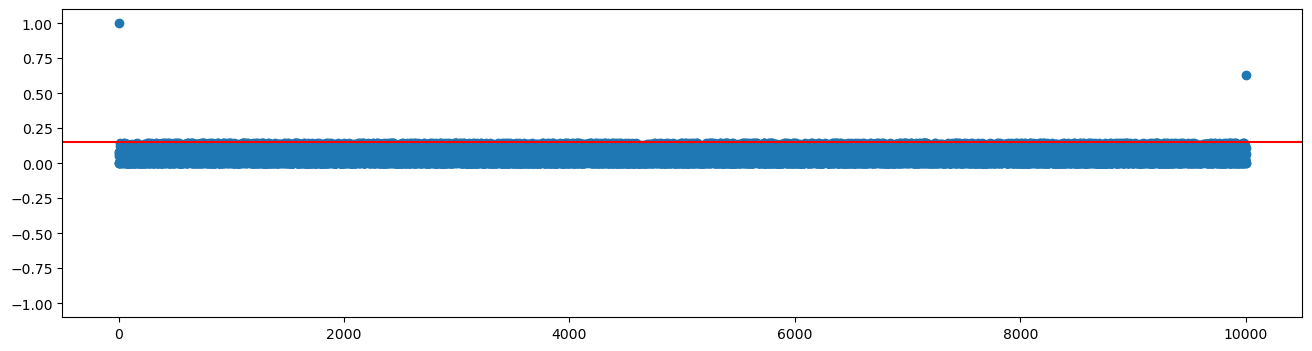

0.6289097795302082


In [79]:
sele_id = 16
fig, ax = plt.subplots(figsize=(16,4))
x = 1:tau+2
y = a_norm_container[sele_id, :]
println(y[end])
ax.plot(x,y, "o")
ax.axhline(0.15, color="red")
ax.set_ylim(-1.1, 1.1)
plt.show()

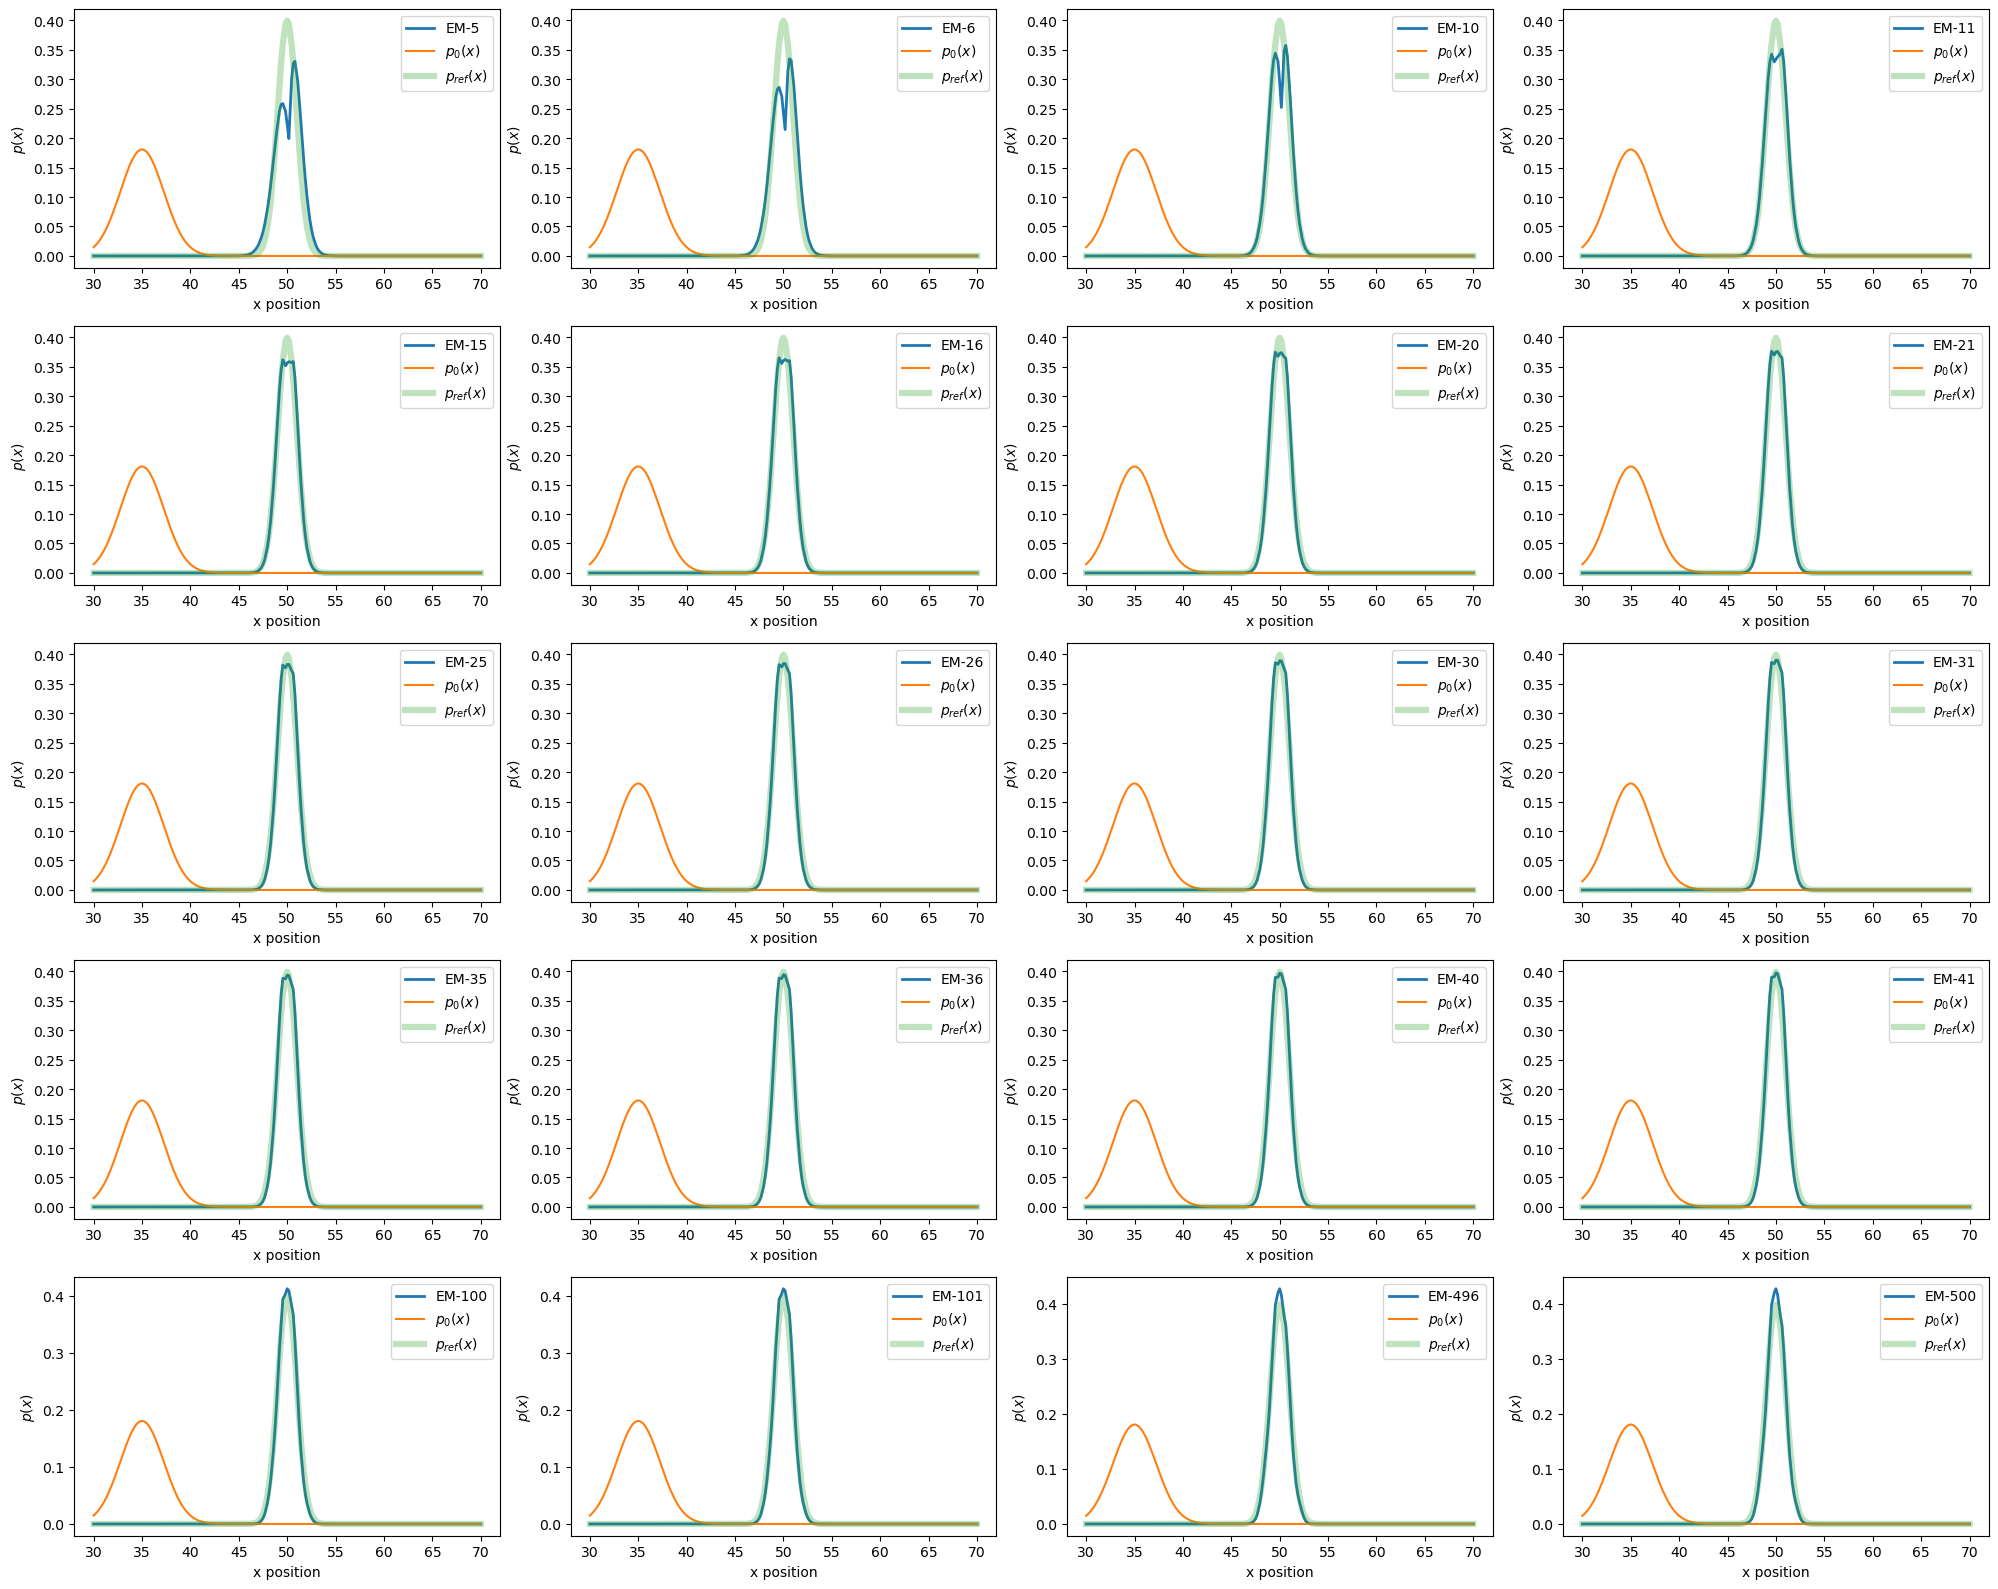

In [10]:
n_rows = 5
n_cols = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,16))

iter_id_seles = [5, 6, 10, 11, 15, 16, 20, 21, 25, 26, 30, 31, 35, 36, 40, 41, 100, 101, 496, 500]

idx = 1
for row_id=1:n_rows
    for col_id=1:n_cols
        ax = axes[row_id, col_id]
        iter_id_sele = iter_id_seles[idx]
        label = @sprintf "EM-%d" iter_id_sele
        ax.plot(xref, p_container[iter_id_sele, :], linewidth=2, label=label, alpha=1)
        ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
        ax.plot(xref, rho_eq .* rho_eq,  linewidth=4.5, alpha=0.3, label="\$ p_{ref}(x) \$")
        ax.legend()
        ax.set_xlabel("x position")
        ax.set_ylabel("\$ p(x) \$")
        idx += 1
    end
end

plt.tight_layout()
#plt.savefig("smooth_iteration.png", dpi=200)
plt.show()

### Part 8: Plot Convergence Plots

In [12]:
x_array, y_array = iteration_evaluation(n_iteration, p_container, peq);

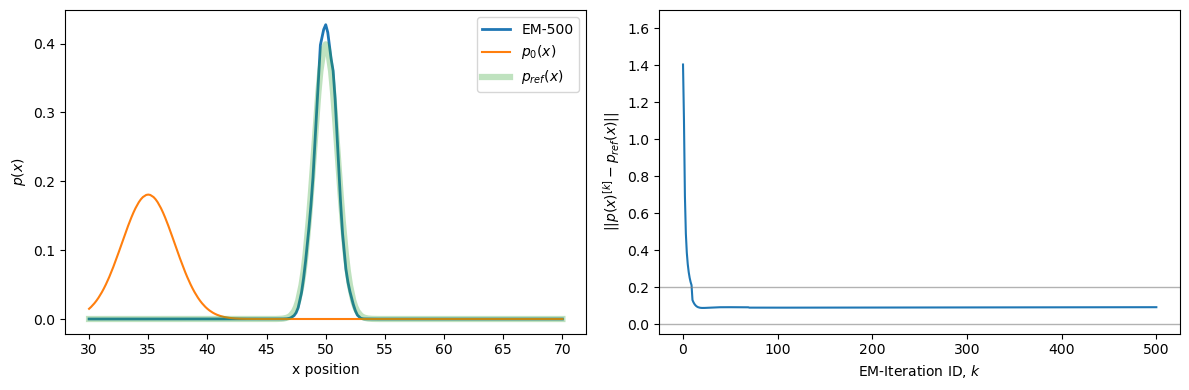

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[1]
iter_id_sele = 500
label = @sprintf "EM-%d" iter_id_sele
ax.plot(xref, p_container[iter_id_sele, :], linewidth=2, label=label, alpha=1)
ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq,  linewidth=4.5, alpha=0.3, label="\$ p_{ref}(x) \$")
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p(x) \$")

ax = axes[2]
ax.plot(x_array, y_array)
ax.set_xlabel("EM-Iteration ID, \$k\$")
ax.set_ylabel("\$ ||p(x)^{[k]} - p_{ref}(x) || \$")
#ax.set_xticks(0:10:100)
ax.set_ylim(-0.05, 1.7)
ax.axhline(0.2, linewidth=1, color="grey", alpha=0.6)
ax.axhline(0, linewidth=1, color="grey", alpha=0.6)

plt.tight_layout()
#plt.savefig("smooth_iteration_convege_plot.png", dpi=200)
plt.show()